In [1]:
import ibmJupyterNotebookStyles
ibmJupyterNotebookStyles.apply_ibm_styles()

## Get started with credit card fraud detection

In this notebook, we show how to detect fraudulent credit card transactions with a quantum-enhanced support vector classifier (QSVC). We take two approaches to enhance the SVC, namely:

1. QSVC enhanced with hyperparameter search for quantum kernel estimation (QKE)<sup>1</sup>
2. QSVC enhanced with quantum kernel alignment (QKA)<sup>2</sup>

We start this tutorial with an introduction to QKE, followed by data loading, QSVC with hyperparameter search, QSVC with QKA, and hyperparameter search on classical SVC. At the end of the tutorial, we provide next steps. 

#### Import packages
This tutorial assumes that `qiskit` and `qiskit-machine-learning` packages have already been installed according to the installation instructions.



In [2]:
# Standard packages
import numpy as np, pandas as pd
import itertools
import matplotlib.pyplot as plt

# scikit-learn
from sklearn.svm import SVC
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,roc_curve,auc
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Qiskit
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap

from qiskit_machine_learning.kernels import FidelityStatevectorKernel

### Implementation

#### Implement quantum kernel estimation

In general, kernels are used to give a measure of similarity between two vectors. A kernel in supervised and unsupervised machine learning is a function that computes the inner product between two vectors in a feature space. These vectors are derived from the original vectors in a Euclidean space by a mapping function that can be nonlinear. Feature space is usually a higher-dimensional space than the original data space.<sup>3</sup>

Kernel function is used in model training and inference to substitute the explicit evaluation of the feature mapping functions (this is known as the “kernel trick”).
In quantum computing, we define the quantum kernel as the Hilbert-Schmidt inner product between two feature vectors $\rho (x)$, $\rho (y)$ in the following way:<br> 

$$K(x,y) = tr[\rho (x) \rho (y)] = {\vert \langle \phi (y) \vert \phi (x) \rangle \vert}^{2},$$  
where the data is nonlinearly mapped to a quantum state $\phi : \vec{x} \in \Omega \rightarrow \vert\phi(x)\rangle\langle\phi(x)\vert$ with $\Omega \in \mathbb{R}^d$ as a subset of the entire data set that represents our test set.<sup>1</sup> We will rewrite this expression to show we could use it as a similarity measure between our input $x$ and target $y$. Writing out the squared expression, we find the following: 

$$ = \langle \phi (y) \vert \phi (x) \rangle^{\dagger} \langle \phi (y) \vert \phi (x) \rangle. $$
Next, we continue to rewrite this expression by using $\langle \phi (y) \vert \phi (x) \rangle^{\dagger} = \langle \phi (x) \vert \phi (y) \rangle$, which yields
$$ = \langle \phi (x) \vert \phi (y) \rangle \langle \phi (y) \vert \phi (x) \rangle. $$
Hence, $\rho(y) = \vert \phi(y) \rangle \langle \phi(y) \vert = U(y) \vert 0 \rangle \langle 0 \vert {U(y)}^{\dagger}.$ Assuming pure states for simplicity,<sup>4</sup> we find 
$$ = \langle \phi (x) \vert \rho_y \vert \phi (x) \rangle. $$

This final identity is a measurement $\langle \phi (x) \vert \rho_y \vert \phi (x) \rangle$ that provides us with information on given input $x$ in feature space $\phi(x)$ about the probability of measuring our target $\rho_y$. To obtain an estimate of this probability, we need to repeat this measurement a number of times. As such, we estimate our quantum kernel.<sup>1</sup>


##### Load the data

So that calculations will not take too long during the training class, we are going to use only five predictors: `V1`–`V5`.<sup>5</sup> Because the data is composed of principal components from the original data, we can reasonably expect that these variables are also among the most important ones; however, this is not explicitly stated in the data description. As an exercise, you can test a different set of predictor variables.<br>

The data is divided into training, validation, and test sets. Models are trained on the training data, and the validation set is used to pick the best model during the grid search. The test set is a completely independent set of data not seen by the model during the training. Note that the data also has a time variable in it. You can create an out-of-time data set, separated from training on a time axis, as an additional exercise. We’ll use about 60% of the original data for training and 20% each for validation and testing. The data is balanced to have 50% fraudulent and 50% genuine transactions in each data set. For convenience, we created appropriate samples from the raw input data that we import in the following code.

In [3]:
# Read the data, split into subsets
data_df = pd.read_pickle("creditcard.zip", \
                         compression = 'zip')
data_df = data_df.drop_duplicates(keep='last', subset=['V1', 'V2', 'V3', 'V4', 'V5'])
print(data_df.shape)

X_train = data_df[data_df["sample"]==0].drop(columns=["sample","y"])
X_test = data_df[data_df["sample"]==2].drop(columns=["sample","y"])
X_val = data_df[data_df["sample"]==1].drop(columns=["sample","y"])
y_train = data_df[data_df["sample"]==0]["y"]
y_test = data_df[data_df["sample"]==2]["y"]
y_val = data_df[data_df["sample"]==1]["y"]

# Standardize
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)

# Normalize
mms = MinMaxScaler((-1, 1))
X_train = mms.fit_transform(X_train)
X_val = mms.transform(X_val)
X_test = mms.transform(X_test)

print("Train set shape", X_train.shape, \
      ", average fraud rate = ",np.mean(y_train),\
      "\nValidation set shape", \
      X_val.shape, ", average fraud rate = ", \
      np.mean(y_val),"\nTest set shape", \
      X_test.shape,", average fraud rate = ",np.mean(y_test))

(965, 7)
Train set shape (570, 5) , average fraud rate =  0.48596491228070177 
Validation set shape (200, 5) , average fraud rate =  0.495 
Test set shape (195, 5) , average fraud rate =  0.49743589743589745


##### Predefine training and validation data sets

To fairly compare quantum and classical models, we must ensure that they are trained and tested on exactly the same data sets. We accomplish this with `PredefinedSplit` as shown, by merging training and validation data together.

In [4]:
X_train_val = np.concatenate((X_train, X_val),axis=0)
y_train_val = np.concatenate((y_train, y_val),axis=0)

predefined_split = np.concatenate(([-1]*y_train.shape[0], \
                                   [0]*y_val.shape[0]))
ps = PredefinedSplit(predefined_split)

##### Set up a hyperparameter search

In this section, we discuss how to set up a hyperparameter search for quantum-classical models. Similar to any machine learning algorithm, our quantum kernel has hyperparameters, settings that we can use to control the behavior of our algorithm.<sup>6,7</sup> In general, hyperparameter tuning is known to be important for the good performance of classical machine learning models and in particular kernel methods.<sup>6</sup>

With quantum kernels, one should specify a feature map and choose its hyperparameters. Unlike classical models, a change of hyperparameters in quantum leads to different models with new decision boundaries.

In this tutorial, we choose the `PauliFeatureMap`.<sup>8</sup> This feature map applies the following transformation on the input data $\vec{x}\in R^n$:  

$$U_{\Phi(\vec{x})}=\exp\left(i\sum_{S\subseteq [n]}\phi_S(\vec{x})\prod_{i\in S} P_i\right),$$

where $P_i \in\{I,X,Y,Z\}$ are the Pauli matrices. The index $S$ describes the connectivity between different qubit data points
$S\in\{\binom{n}{k} \space \text{combinations} \space k=1,2,..,n\}$, which results in 

$$\phi_S(\vec{x}) = \begin{cases}
            x_0, \text{ if } k = 1 \\
            \prod_{j \in S} (\pi - x_j), \text{ otherwise.}
            \end{cases}$$

This circuit could contain repetitions ($reps$) of this transformation. Below, an example circuit of `PauliFeatureMap` is shown. The hyperparameter $\alpha$ is the Pauli rotation factor, multiplicative to the Pauli rotations. 

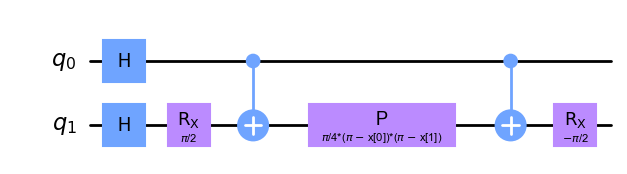

In [5]:
pf = PauliFeatureMap(feature_dimension=2, \
                                  alpha=(np.pi/4), \
                                  reps=1, \
                                  paulis=["YZ"], \
                                  entanglement=["full"] \
                                 )

pf.decompose().draw(output="mpl", style="clifford")

Next, we define a grid of parameters, perform a grid search, and try all possible combinations on the grid. Thus, we define the parameter grid for the kernel, transform it into a list of kernels, and capture kernel/parameter references in a dictionary object. We now can look up parameters that correspond to the selected kernel. We use a limited parameter grid to complete the process within a reasonable time.

**Note on the implementation below**

We use the `FidelityStatevectorKernel` as a kernel for the `SVC` algorithm. This uses under the hood a `Statevector` simulator, which is appropriate for fast small scale computatations. It is fast, but it doesn't allow for more flexible settings. If you want to experiment with a more flexible approach, that could also be applicable for using quantum hardware, you need to replace the `FidelityStatevectorKernel` with the `FidelityQuantumKernel`, which can be setup as follows:

```python
    from qiskit_algorithms.state_fidelities import ComputeUncompute
    from qiskit_machine_learning.kernels import FidelityQuantumKernel

    # here the Sampler is a sampler primitive, which will be a runtime sampler
    # primitive if we want to use the hardware
    fidelity = ComputeUncompute(sampler=Sampler())

    kernel = FidelityQuantumKernel(feature_map=feature_map, fidelity=fidelity)

    # the kernel defined above would replace the kernel defined in the next cell

    #   ...
    #   kernel = FidelityStatevectorKernel(feature_map=feature_map)
    #   ...

```

In [6]:
kernels = [] # list for kernel callables
kernels_dict = dict() # dictionary for lookup of kernel parameters

# Kernels grid
grid_params_kernel = dict()
grid_params_kernel["alpha"] = [0.5,1,2]
grid_params_kernel["paulis"] = [["Y"],["Z"],["YZ"],["ZZ"]]
grid_params_kernel["reps"] = [1]
grid_params_kernel["entanglement"] = ["full"]

feature_dim = X_train.shape[1]

# Extracting all combinations of kernel parameters
grid_params_kernel_values = \
    list(itertools.product(*grid_params_kernel.values()))

# Converting parameters grid into list of kernel callables
for alpha,pauli,reps,entanglement in grid_params_kernel_values:

    feature_map = PauliFeatureMap(feature_dimension=feature_dim, \
                                  alpha=alpha, \
                                  reps=reps, \
                                  paulis=pauli, \
                                  entanglement=entanglement \
                                 )
    kernel = FidelityStatevectorKernel(feature_map=feature_map)
    obj_str = str(kernel)
    obj_str = obj_str[obj_str.find("0x"):-1]

    kernels_dict[obj_str] = {"alpha":alpha, \
                             "paulis":pauli, \
                             "reps":reps, \
                             "entanglement":entanglement
                            }

    kernels.append(kernel.evaluate)

Next, we combine the kernel grid with classical model parameters and start estimation.

**Note:** We currently use the **`statevector`** simulator, so for smaller problems it makes sense to run multiple jobs in parallel. If you use a physical backend, you might want to run tasks sequentially and use Qiskit Runtime.

In [7]:
# Define the classical parameter grid for SVM with quantum kernel
params_qsvc = {'C':[1,10]}
# We use kernel objects themselves as parameters. 
# After the training we would need to map the selected kernel 
# back to kernel parameters.
params_qsvc['kernel'] = kernels

# Estimator to be used in GridSearchCV
svc = SVC(probability=True) 

# Define grid search estimator with parameters grid, 
# predefined split and parallel processing
estimator_q = GridSearchCV(svc, params_qsvc, n_jobs=1, verbose=1, cv=ps)
estimator_q.fit(X = X_train_val,y = y_train_val)

# The next line is very verbose. Uncomment to see 
# detailed results.
#print("All results -----------\n", estimator.cv_results_)
print("Best ------------------\n", estimator_q.best_params_)
q_kernel_obj_str = str(estimator_q.best_params_.get('kernel'))
# Retrieving kernel parameters for the best kernel
q_kernel_obj_str = q_kernel_obj_str[q_kernel_obj_str.find("0x"):-2]
print("Best kernel -----------\n",kernels_dict[q_kernel_obj_str])

Fitting 1 folds for each of 24 candidates, totalling 24 fits
Best ------------------
 {'C': 1, 'kernel': <bound method FidelityStatevectorKernel.evaluate of <qiskit_machine_learning.kernels.fidelity_statevector_kernel.FidelityStatevectorKernel object at 0x17539d570>>}
Best kernel -----------
 {'alpha': 1, 'paulis': ['ZZ'], 'reps': 1, 'entanglement': 'full'}


In [8]:
# Retrieve kernel parameters for grid search iterations
test_scores = estimator_q.cv_results_['split0_test_score']
params = estimator_q.cv_results_['params']

for i_param in params:
    q_kernel_obj_str = str(i_param['kernel'])
    q_kernel_obj_str = q_kernel_obj_str[q_kernel_obj_str.find("0x"):-2]
    i_param["kernel"] = kernels_dict[q_kernel_obj_str]

for i,i_param in enumerate(params):
    i_param['test_score'] = test_scores[i]

The grid search was performed on both classical and quantum kernel parameters. You can print out the full history of results. In general, you can use this procedure to choose the best model as well as to assist in finding the most suitable quantum kernel and feature map topology.<br>

Below, we print out classification metrics (classification report and receiver operatoring characteristic [ROC] curves).

In [9]:
y_train_pred = estimator_q.best_estimator_.predict(X_train)
y_train_pred_scores = estimator_q.best_estimator_.predict_proba(X_train)
y_test_pred_q = estimator_q.best_estimator_.predict(X_test)
y_test_pred_scores_q = estimator_q.best_estimator_.predict_proba(X_test)
y_val_pred = estimator_q.best_estimator_.predict(X_val)
y_val_pred_scores = estimator_q.best_estimator_.predict_proba(X_val)
print("Confusion matrix, Test \n",confusion_matrix(y_test, y_test_pred_q))
print("Confusion matrix, Train \n",confusion_matrix(y_train, y_train_pred))
print("Confusion matrix, Validation \n",confusion_matrix(y_val, y_val_pred))
#print(classification_report(y_test, y_test_pred))
accuracy = accuracy_score(y_test, y_test_pred_q)
print("Accuracy test: %.2f%%" % (accuracy * 100.0))
accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy train: %.2f%%" % (accuracy * 100.0))
accuracy = accuracy_score(y_val, y_val_pred)
print("Accuracy val: %.2f%%" % (accuracy * 100.0))

cr_train = classification_report(y_train, y_train_pred,output_dict=False)
cr_test = classification_report(y_test, y_test_pred_q,output_dict=False)
cr_val = classification_report(y_val, y_val_pred,output_dict=False)

print('train',cr_train,'\nval',cr_val,'\ntest',cr_test)

Confusion matrix, Test 
 [[92  6]
 [11 86]]
Confusion matrix, Train 
 [[286   7]
 [ 31 246]]
Confusion matrix, Validation 
 [[97  4]
 [ 9 90]]
Accuracy test: 91.28%
Accuracy train: 93.33%
Accuracy val: 93.50%
train               precision    recall  f1-score   support

         0.0       0.90      0.98      0.94       293
         1.0       0.97      0.89      0.93       277

    accuracy                           0.93       570
   macro avg       0.94      0.93      0.93       570
weighted avg       0.94      0.93      0.93       570
 
val               precision    recall  f1-score   support

         0.0       0.92      0.96      0.94       101
         1.0       0.96      0.91      0.93        99

    accuracy                           0.94       200
   macro avg       0.94      0.93      0.93       200
weighted avg       0.94      0.94      0.93       200
 
test               precision    recall  f1-score   support

         0.0       0.89      0.94      0.92        98
         1.

##### Visualize the results using ROC curves

The ROC curve plots false positives versus true positives. The further the line is from the 45-degree random line,  the better the classifier is. A metric called the “area under the curve” (AUC) provides a single-number summary of the ROC curve.

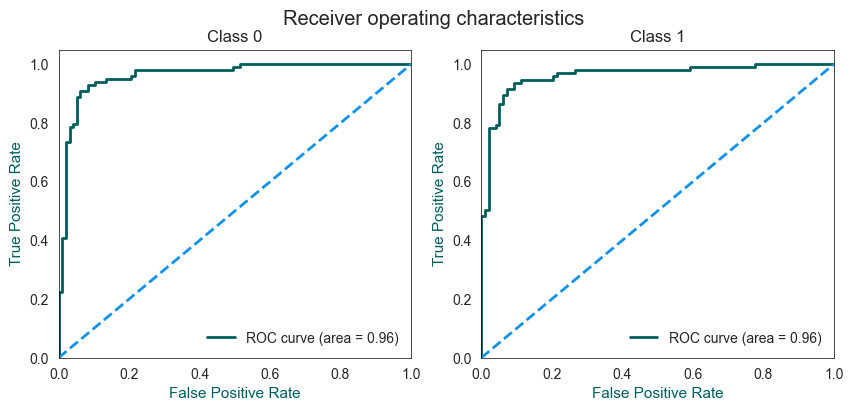

In [10]:
fpr = dict()
tpr = dict()
roc_auc = dict()

fig, axs = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('Receiver operating characteristics')
lw = 2

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve((np.array([[0,1] if row==1 else [1,0] for row in y_test]))[:, i], y_test_pred_scores_q[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    axs[i].plot(fpr[i], tpr[i], color='#005D5D',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
    axs[i].plot([0, 1], [0, 1], color='#1192E8', lw=lw, linestyle='--')
    axs[i].set_title("Class %0.0f" % i)
    axs[i].set_xlim([0.0, 1.0])
    axs[i].set_ylim([0.0, 1.05])
    axs[i].set_xlabel('False Positive Rate')
    axs[i].set_ylabel('True Positive Rate')
    axs[i].legend(loc="lower right")
    
plt.show()

#### Implement quantum kernel alignment

Another technique for improving the performance of kernel methods is kernel alignment. We will use quantum kernel alignment (QKA) to chose the best fiducial state in the kernel function from a family of states.<sup>9</sup> This is done by a parameterized quantum kernel, which applies an additional variational quantum circuit $V_{\lambda}$ with parameter $\lambda$ to the state $\vert \phi_\lambda \rangle = V_\lambda \vert 0^n\rangle$. This yields the following parameterized kernel:

$$K_{\lambda}(x,z)= {\vert \langle 0^n \vert V_{\lambda}^\dagger D_x^\dagger D_x V_{\lambda} \vert 0^n \rangle \vert}^{2},$$

where $D_x V_\lambda$ is our feature map circuit.<sup>2</sup> To find the optimal hyperplane for our classification problem using QSVC, the following optimization problem needs to be solved:

$$F(\alpha, \lambda)= \sum^m_{i=1} \alpha_i - \frac{1}{2} \sum^m_{i,j=1} \alpha_i \alpha_j y_i y_j K_\lambda(x_i,x_j),$$


where we want to maximize for $\alpha$, the Lagrange multiplier, and minimize the function for $\lambda$, which results in the $min_\lambda max_\alpha F(\alpha, \lambda)$ problem.<sup>2</sup>



In [11]:
from qiskit.circuit import ParameterVector 
from qiskit import QuantumCircuit
from qiskit_algorithms.optimizers import SPSA
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_machine_learning.algorithms import QSVC

In [12]:
# Create a rotational layer to train. We will rotate each qubit the same amount.
user_params = ParameterVector("θ", 1)
fm0 = QuantumCircuit(5)
fm0.ry(user_params[0], range(feature_dim))

# Use ZZFeatureMap to represent input data
fm1 = ZZFeatureMap(feature_dim, reps=1, entanglement='full')

# Create the feature map, composed of our two circuits
fm = fm0.compose(fm1)

# print(circuit_drawer(fm))
print(f"Trainable parameters: {user_params}")

Trainable parameters: θ, ['θ[0]']


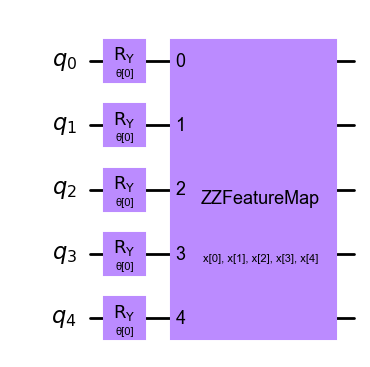

In [13]:
fm.draw('mpl', style='clifford')

In the cell below we train a `FidelityStatevectorKernel` kernel by using the specific trainable kernel version `TrainableFidelityStatevectorKernel`. Similarly with what was mentioned above, the more generic approach would be to use `TrainableFidelityQuantumKernel` to train a `FidelityQuantumKernel` and the code below will need to be changed as follows:

```python
    from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel

    # Instantiate the quantum kernel
    # the fidelity was defined above
    quant_kernel = TrainableFidelityQuantumKernel(feature_map=fm,
                                                  fidelity=fidelity,
                                                  training_parameters=user_params)
```

In [14]:
from qiskit_machine_learning.kernels import TrainableFidelityStatevectorKernel
# Instantiate the quantum kernel
quant_kernel = TrainableFidelityStatevectorKernel(feature_map=fm, training_parameters=user_params)

# Set up the optimizer
spsa_opt = SPSA(maxiter=30, 
                learning_rate=0.05, 
                perturbation=0.05)

# Instantiate a quantum kernel trainer.
qkt = QuantumKernelTrainer(quantum_kernel=quant_kernel, loss='svc_loss', 
                           optimizer=spsa_opt, initial_point=[np.pi/2])

In [15]:
qka_results = qkt.fit(X_train_val, y_train_val)
optimized_kernel = qka_results.quantum_kernel

In [16]:
# Use QSVC for classification
qsvc = QSVC(quantum_kernel=optimized_kernel, probability=True)

# Fit the QSVC
qsvc.fit(X_train_val, y_train_val)

QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', max_iter=-1,
     probability=True,
     quantum_kernel=<qiskit_machine_learning.kernels.trainable_fidelity_statevector_kernel.TrainableFidelityStatevectorKernel object at 0x1764eeef0>,
     random_state=None, shrinking=True, tol=0.001, verbose=False)

In [17]:
y_train_pred = qsvc.predict(X_train)
y_train_pred_scores = qsvc.predict_proba(X_train)
y_test_pred_q = qsvc.predict(X_test)
y_test_pred_scores_q = qsvc.predict_proba(X_test)
y_val_pred = qsvc.predict(X_val)
y_val_pred_scores = qsvc.predict_proba(X_val)

print("Confusion matrix, Test \n",confusion_matrix(y_test, y_test_pred_q))
print("Confusion matrix, Train \n",confusion_matrix(y_train, y_train_pred))
print("Confusion matrix, Validation \n",confusion_matrix(y_val, y_val_pred))
#print(classification_report(y_test, y_test_pred))

accuracy = accuracy_score(y_test, y_test_pred_q)
print("Accuracy test: %.2f%%" % (accuracy * 100.0))
accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy train: %.2f%%" % (accuracy * 100.0))
accuracy = accuracy_score(y_val, y_val_pred)
print("Accuracy val: %.2f%%" % (accuracy * 100.0))

cr_train = classification_report(y_train, y_train_pred,output_dict=False)
cr_test = classification_report(y_test, y_test_pred_q,output_dict=False)
cr_val = classification_report(y_val, y_val_pred,output_dict=False)

print('train',cr_train,'\nval',cr_val,'\ntest',cr_test)

Confusion matrix, Test 
 [[89  9]
 [ 7 90]]
Confusion matrix, Train 
 [[268  25]
 [ 23 254]]
Confusion matrix, Validation 
 [[94  7]
 [ 8 91]]
Accuracy test: 91.79%
Accuracy train: 91.58%
Accuracy val: 92.50%
train               precision    recall  f1-score   support

         0.0       0.92      0.91      0.92       293
         1.0       0.91      0.92      0.91       277

    accuracy                           0.92       570
   macro avg       0.92      0.92      0.92       570
weighted avg       0.92      0.92      0.92       570
 
val               precision    recall  f1-score   support

         0.0       0.92      0.93      0.93       101
         1.0       0.93      0.92      0.92        99

    accuracy                           0.93       200
   macro avg       0.93      0.92      0.92       200
weighted avg       0.93      0.93      0.92       200
 
test               precision    recall  f1-score   support

         0.0       0.93      0.91      0.92        98
         1.

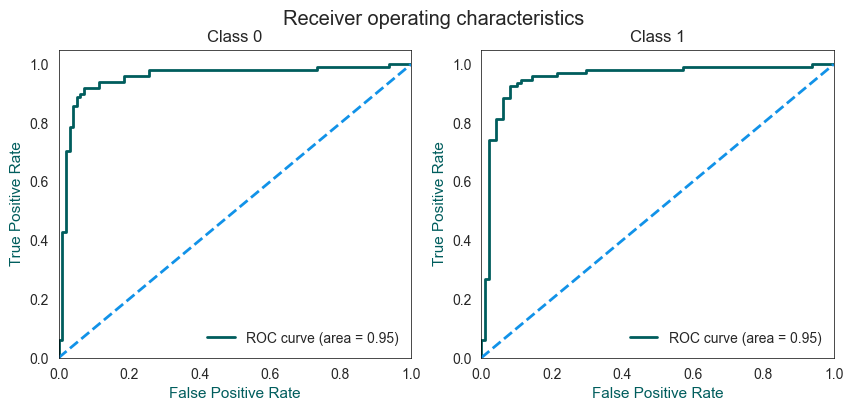

In [18]:
fpr = dict()
tpr = dict()
roc_auc = dict()

fig, axs = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('Receiver operating characteristics')
lw = 2

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve((np.array([[0,1] if row==1 else [1,0] for row in y_test]))[:, i], y_test_pred_scores_q[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    axs[i].plot(fpr[i], tpr[i], color='#005D5D',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
    axs[i].plot([0, 1], [0, 1], color='#1192E8', lw=lw, linestyle='--')
    axs[i].set_title("Class %0.0f" % i)
    axs[i].set_xlim([0.0, 1.0])
    axs[i].set_ylim([0.0, 1.05])
    axs[i].set_xlabel('False Positive Rate')
    axs[i].set_ylabel('True Positive Rate')
    axs[i].legend(loc="lower right")
    
plt.show()

As we can see from the results above, we were able to obtain a slight improvement in the performance of the QSVM by utilizing the kernel alignment procedure. 

#### Apply classical SVM

Next, we train the support vector machine (SVM) with classical kernels and perform hyperparameter tuning.

In [19]:
# Specify grid for SVM
parameters_svm = {'kernel':('linear', 'rbf'), \
              'C':[0.1, 1, 10, 100], \
              'gamma':['scale', 'auto',0.0001,0.001,0.01,0.1,1,10], \
              'probability': [True]
             }
# Initialize classifier and fit
svc = SVC()
estimator_r = GridSearchCV(svc, parameters_svm, n_jobs=-1, \
                           verbose=1, cv=ps)
estimator_r.fit(X = X_train_val,y = y_train_val)

selected_params = estimator_r.best_estimator_.get_params()
selected_params = {k: selected_params[k] for k in \
                   parameters_svm.keys()}

print("Selected parameters:/n",selected_params)

Fitting 1 folds for each of 64 candidates, totalling 64 fits


Selected parameters:/n {'kernel': 'rbf', 'C': 1, 'gamma': 10, 'probability': True}


##### Print classification results

In [20]:
y_train_pred = estimator_r.best_estimator_.predict(X_train)
y_train_pred_scores = estimator_r.best_estimator_.predict_proba(X_train)
y_test_pred_r = estimator_r.best_estimator_.predict(X_test)
y_test_pred_scores_r = estimator_r.best_estimator_.predict_proba(X_test)
y_val_pred = estimator_r.best_estimator_.predict(X_val)
y_val_pred_scores = estimator_r.best_estimator_.predict_proba(X_val)
print("Confusion matrix, Test \n",confusion_matrix(y_test, y_test_pred_r))
print("Confusion matrix, Train \n",confusion_matrix(y_train, y_train_pred))
print("Confusion matrix, Validation \n",confusion_matrix(y_val, y_val_pred))
accuracy = accuracy_score(y_test, y_test_pred_r)
print("Accuracy test: %.2f%%" % (accuracy * 100.0))
accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy train: %.2f%%" % (accuracy * 100.0))
accuracy = accuracy_score(y_val, y_val_pred)
print("Accuracy val: %.2f%%" % (accuracy * 100.0))

cr_train = classification_report(y_train, y_train_pred,output_dict=False)
cr_test = classification_report(y_test, y_test_pred_r,output_dict=False)
cr_val = classification_report(y_val, y_val_pred,output_dict=False)

print('train',cr_train,'\nval',cr_val,'\ntest',cr_test)

Confusion matrix, Test 
 [[92  6]
 [ 9 88]]
Confusion matrix, Train 
 [[285   8]
 [ 26 251]]
Confusion matrix, Validation 
 [[98  3]
 [ 8 91]]
Accuracy test: 92.31%
Accuracy train: 94.04%
Accuracy val: 94.50%
train               precision    recall  f1-score   support

         0.0       0.92      0.97      0.94       293
         1.0       0.97      0.91      0.94       277

    accuracy                           0.94       570
   macro avg       0.94      0.94      0.94       570
weighted avg       0.94      0.94      0.94       570
 
val               precision    recall  f1-score   support

         0.0       0.92      0.97      0.95       101
         1.0       0.97      0.92      0.94        99

    accuracy                           0.94       200
   macro avg       0.95      0.94      0.94       200
weighted avg       0.95      0.94      0.94       200
 
test               precision    recall  f1-score   support

         0.0       0.91      0.94      0.92        98
         1.

##### Visualize the results using ROC curves

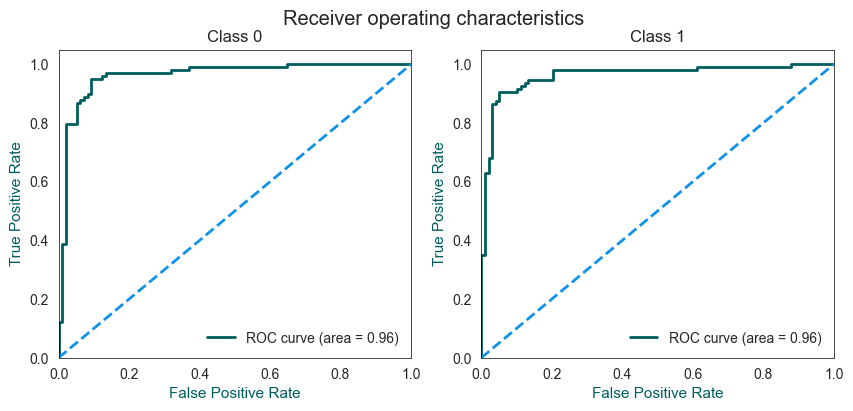

In [21]:
fpr = dict()
tpr = dict()
roc_auc = dict()

fig, axs = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('Receiver operating characteristics')
lw = 2

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve((np.array([[0,1] if row==1 else [1,0] for row in y_test]))[:, i], y_test_pred_scores_r[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    axs[i].plot(fpr[i], tpr[i], color='#005D5D',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
    axs[i].plot([0, 1], [0, 1], color='#1192E8', lw=lw, linestyle='--')
    axs[i].set_title("Class %0.0f" % i)
    axs[i].set_xlim([0.0, 1.0])
    axs[i].set_ylim([0.0, 1.05])
    axs[i].set_xlabel('False Positive Rate')
    axs[i].set_ylabel('True Positive Rate')
    axs[i].legend(loc="lower right")
    
plt.show()

### Summary

In this notebook, we showed how to implement QSVR. We demonstrated two approaches for improving performance, namely through hyperparameter search for QKE and QSVR enhanced with QKA.

For next steps, we recommend the following:
- Download this notebook and experiment with your own data set for classification problems.
- Extend the list of predefined hyperparameters in the grid search.
- Try a different variant of kernel alignment, such as centered kernel alignment. 

### References

1. <a id='Havlicek2019'></a>Vojtech Havlicek et al. “Supervised Learning with Quantum Enhanced Feature Spaces.” arXiv:1804.11326, 2018. https://arxiv.org/abs/1804.11326.

2. <a id='covariant_kernel'></a>Jennifer R. Glick et al. “Covariant Quantum Kernels for Data with Group Structure.” arXiv:2105.03406, 2021. https://arxiv.org/abs/2105.03406.

3. <a id='Hofmann2008'></a>Thomas Hofmann, Bernard Schölkopf, and Alexander J. Smola. “Kernel Methods in Machine Learning.” arXiv:math/0701907v3, July 1, 2008. https://arxiv.org/abs/math/0701907.

4. <a id='Schuld2021'></a>Maria Schuld. “Supervised Quantum Machine Learning Models Are Kernel Methods.” arXiv:2101.11020, April 17, 2021. https://arxiv.org/abs/2101.11020.

5. <a id='KaggleData2018'></a>“Credit Card Fraud Detection: Anonymized Credit Card Transactions Labeled as Fraudulent or Genuine.” *Kaggle*, 2018. https://www.kaggle.com/mlg-ulb/creditcardfraud.

6. <a id='kernel_trainer'></a>Ian Goodfellow, Yoshua Bengio, and Aaron Courville. *Deep Learning*. Cambridge: MIT Press, 2016. http://www.deeplearningbook.org.

7. <a id='kernel_trainer'></a>Ruslan Shaydulin and Stefan M. Wild. “Importance of Kernel Bandwidth in Quantum Machine Learning.” arXiv:2111.05451v4, September 28, 2022. https://arxiv.org/abs/2111.05451.

8. <a id='QiskitPauli'></a>“PauliFeatureMap.” *Qiskit*. https://qiskit.org/documentation/stubs/qiskit.circuit.library.PauliFeatureMap.html.

9. <a id='kernel_trainer'></a>“Quantum Kernel Training for Machine Learning Applications.” *Qiskit*. https://qiskit.org/documentation/machine-learning/tutorials/08_quantum_kernel_trainer.html.

<span style="font-size:10pt; font-weight:bold;" class = "copyright-content"> &copy; Copyright IBM Corp. 2023 <br/>This content is categorized as an “existing” IBM asset as part of the IBM Quantum Accelerator contract. </span>